In [43]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import zipfile
import cv2
from tqdm import tqdm
import json
import pandas as pd

In [44]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [45]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")   # please manually install torch 1.8 if Colab changes its default version

1.8.0+cu101 True


In [46]:
def visualizerDet(cfg,im,outputs):
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  return v.draw_instance_predictions(outputs["instances"].to("cpu"))

In [47]:
def visualizerPan(cfg,im,panoptic_seg):
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  return v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)

In [48]:
def configmodel(path):
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file(path))
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(path)
  return cfg


In [49]:
def modelpredictor(modelpath):
  cfg = configmodel(modelpath)
  predictor = DefaultPredictor(cfg)
  return predictor

# Preparing COCO Dataset Images in batches

In [50]:
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# with zipfile.ZipFile('./annotations_trainval2017.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [51]:
dataDir='..'
dataType='val2017'
annFile='/content/annotations/instances_val2017.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


In [52]:
catIds = coco.getCatIds(catNms=['skateboard'])
imgIds = coco.getImgIds(catIds=catIds )


# Initializing the Models


In [53]:
RCM_model = modelpredictor("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
panoptic_model = modelpredictor("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")

In [54]:
new_anno = {}
new_idx = -1 
for  idx in imgIds:
  
  boxes = []
  img = coco.loadImgs(idx)[0]
  I = io.imread(img['coco_url'])
  if len(I.shape) == 2:
    continue
  outputs = RCM_model(I)
  panoptic_seg, segments_info = panoptic_model(I)["panoptic_seg"]
  hassky = False
  for cat in segments_info:
    if cat['category_id'] == 40:
      SkyClass = cat['id']
      hassky = True
      break
  im = panoptic_seg.detach().cpu().numpy()
  if hassky:
    max_x,max_y = np.where(im== SkyClass)
    max_x,max_y = max_x[-1], max_y[-1]
    im = I[max_x:,:].copy()
  else :
    im = I.copy()
  
  for box in outputs['instances'].pred_boxes:
    x,y,w,h = box.detach().cpu().numpy().astype(np.int)
  
    if  hassky:
      h = max(h-max_x,0)
      y = max(y-max_x,0)
    if h <=0:
      continue

  if h == 0:
    continue
  new_idx +=1 
  boxes.append([x,y,w,h])
  new_anno[str(new_idx)] = boxes
  cv2.imwrite('/content/outputs/SkylessDataset/'+str(new_idx)+'.png',im)
  




In [76]:
df = pd.DataFrame.from_dict(new_anno)
df.to_json('/content/outputs/Annotations/SkyLessAnno.json')


# Inference

In [77]:
 img = coco.loadImgs(imgIds[np.random.randint(len(imgIds))])[0]
I = io.imread(img['coco_url'])


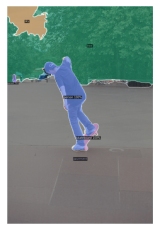

In [78]:
# Sky Segmentation
cfg = configmodel("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
panoptic_seg, segments_info = panoptic_model(I)["panoptic_seg"]
out_seg = visualizerPan(cfg,I,panoptic_seg)

plt.imshow(out_seg.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

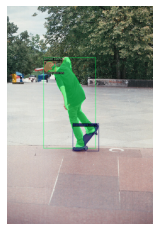

In [82]:
# Detection
cfg = configmodel("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
outputs = RCM_model(I)

out = visualizerDet(cfg,I,outputs)
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

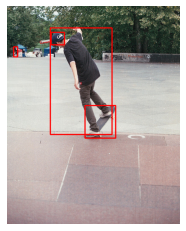

In [80]:
# Cropping
for cat in segments_info:
  if cat['category_id'] == 40:
    SkyClass = cat['id']
    hassky = True
    break
im = panoptic_seg.detach().cpu().numpy()
if hassky:
  max_x,max_y = np.where(im== SkyClass)
  max_x,max_y = max_x[-1], max_y[-1]
  im = I[max_x:,:].copy()
else :
  im = I.copy()

for box in outputs['instances'].pred_boxes:
  x,y,w,h = box.detach().cpu().numpy().astype(np.int)

  if  hassky:
    h = max(h-max_x,0)
    y = max(y-max_x,0)
  if h <=0:
    continue
  cv2.rectangle(im,(x, y), (w, h), (255,0,0), 2)
plt.imshow(im)
plt.axis('off')
plt.show()

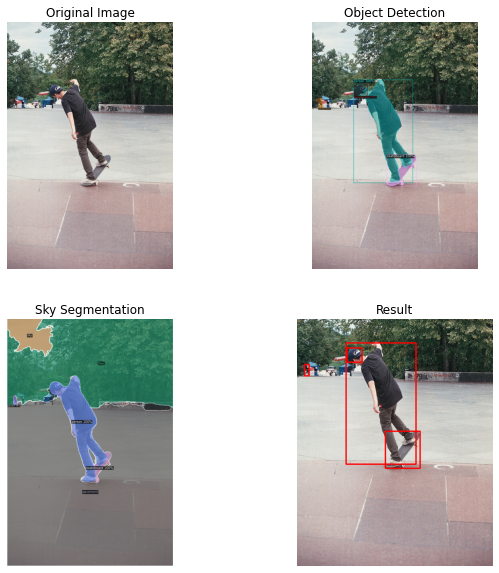

In [81]:
plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
plt.title("Original Image")
plt.imshow(I)
plt.axis('off')
plt.subplot(2,2,2)
plt.title("Object Detection")
plt.axis('off')
plt.imshow(out.get_image()[:, :, ::-1])
plt.subplot(2,2,3)
plt.title("Sky Segmentation")
plt.axis('off')
plt.imshow(out_seg.get_image()[:, :, ::-1])
plt.subplot(2,2,4)
plt.title("Result")
plt.axis('off')
plt.imshow(im)
plt.show()